In [1]:
import torch
import torchvision
import torchvision.transforms as transforms
from torch.utils.data import DataLoader, random_split
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd


In [2]:
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
print(f"Using device {device}")

Using device cuda


In [6]:
transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((0.5,0.5,0.5),(0.5,0.5,0.5))
])


full_train_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=True,
    download=True,
    transform=transform
)


test_dataset = torchvision.datasets.CIFAR10(
    root='./data',
    train=False,
    download=True,
    transform=transform
)

100%|██████████| 170M/170M [00:02<00:00, 75.7MB/s]


In [10]:
train_size = int(0.8 * len(full_train_dataset))
val_size = len(full_train_dataset) - train_size

train_dataset, val_dataset = random_split(full_train_dataset, [train_size, val_size])

print(f"Train dataset: {len(train_dataset)}")
print(f"Validate dataset: {len(val_dataset)}")
print(f"Test dataset: {len(test_dataset)}")

Train dataset: 40000
Validate dataset: 10000
Test dataset: 10000


In [14]:
BATCH_SIZE = 64

train_loader = DataLoader(train_dataset, batch_size=BATCH_SIZE, shuffle=True)
val_loader = DataLoader(val_dataset, batch_size=BATCH_SIZE, shuffle=False)
test_loader = DataLoader(test_dataset, batch_size=BATCH_SIZE, shuffle=False)

classes = ('plane','car','bird','cat','deer','dog','frog','horse','ship','truck')

In [19]:
def imshow(img):
  img = img / 2 + 0.5
  npimg = img.numpy()
  plt.imshow(np.transpose(npimg, (1,2,0)))
  plt.show()

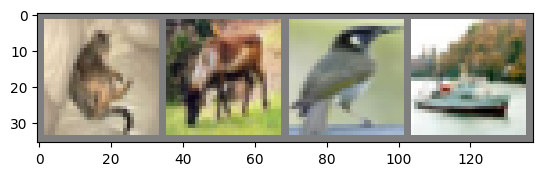

cat  deer bird ship 


In [20]:
dataiter = iter(train_loader)
images, labels = next(dataiter)

imshow(torchvision.utils.make_grid(images[:4]))
print("".join(f"{classes[labels[j]]:5s}" for j in range(4)))

In [22]:
import torch.nn as nn
import torch.nn.functional as F

In [29]:
class SimpleCNN(nn.Module):
  def __init__(self):
    super(SimpleCNN, self).__init__()

    #input 3 channels - RGB
    #padding=1 saving picture size
    self.conv1 = nn.Conv2d(in_channels=3, out_channels=32, kernel_size=3, padding=1)
    self.conv2 = nn.Conv2d(in_channels=32, out_channels=64, kernel_size=3, padding=1)
    self.conv3 = nn.Conv2d(in_channels=64, out_channels=128, kernel_size=3, padding=1)

    self.pool = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc1 = nn.Linear(128*4*4, 512)
    self.fc2 = nn.Linear(512, 10)

    self.dropout = nn.Dropout(0.25)

  def forward(self, x):

    x = self.pool(F.relu(self.conv1(x)))
    x = self.pool(F.relu(self.conv2(x)))
    x = self.pool(F.relu(self.conv3(x)))

    x = x.view(-1, 128*4*4)

    x = self.dropout(x)
    x = F.relu(self.fc1(x))
    x = self.fc2(x)

    return x

In [30]:
net = SimpleCNN().to(device)
print(net)

SimpleCNN(
  (conv1): Conv2d(3, 32, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv2): Conv2d(32, 64, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (conv3): Conv2d(64, 128, kernel_size=(3, 3), stride=(1, 1), padding=(1, 1))
  (pool): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
  (fc1): Linear(in_features=2048, out_features=512, bias=True)
  (fc2): Linear(in_features=512, out_features=10, bias=True)
  (dropout): Dropout(p=0.25, inplace=False)
)


In [31]:
import torch.optim as optim

In [32]:
criterion = nn.CrossEntropyLoss()
optimizer = optim.SGD(net.parameters(), lr=0.001, momentum=0.9)

In [33]:
EPOCHS=10
print(f"Training on: {device}")

history = {
    'train_loss': [], 'train_acc' : [],
    'val_loss' : [], 'val_acc' : []
}


for epoch in range(EPOCHS):
  net.train()
  running_loss = 0.0
  correct_train = 0
  total_train = 0

  for i, data in enumerate(train_loader, 0):
    inputs, labels = data
    inputs, labels = inputs.to(device), labels.to(device)

    optimizer.zero_grad()

    outputs = net(inputs)
    loss = criterion(outputs, labels)

    loss.backward()
    optimizer.step()

    running_loss += loss.item()
    _, predicted = torch.max(outputs.data, 1)
    total_train += labels.size(0)
    correct_train += (predicted == labels).sum().item()


  avg_train_loss = running_loss / len(train_loader)
  train_acc = 100 * correct_train / total_train

  net.eval()
  val_loss = 0.0
  correct_val = 0
  total_val = 0

  with torch.no_grad():
    for data in val_loader:
      inputs, labels = data
      inputs, labels = inputs.to(device), labels.to(device)

      outputs = net(inputs)
      loss = criterion(outputs, labels)

      val_loss += loss.item()
      _, predicted = torch.max(outputs.data, 1)
      total_val += labels.size(0)
      correct_val += (predicted == labels).sum().item()

  avg_val_loss = val_loss / len(val_loader)
  val_acc = 100 * correct_val / total_val

  history['train_loss'].append(avg_train_loss)
  history['train_acc'].append(train_acc)
  history['val_loss'].append(avg_val_loss)
  history['val_acc'].append(val_acc)


  print(f"Epoch [{epoch+1}/{EPOCHS}] "
        f"Train loss: {avg_train_loss:.4f} | Train acc: {train_acc:.2f}% ||"
        f"Val loss: {avg_val_loss:.4f} | Val acc {val_acc:.2f}%")

Training on: cuda
Epoch [1/10] Train loss: 2.2787 | Train acc: 14.62% ||Val loss: 2.1920 | Val acc 23.13%
Epoch [2/10] Train loss: 2.0137 | Train acc: 28.08% ||Val loss: 1.8627 | Val acc 33.99%
Epoch [3/10] Train loss: 1.7767 | Train acc: 36.15% ||Val loss: 1.6764 | Val acc 40.39%
Epoch [4/10] Train loss: 1.6203 | Train acc: 41.20% ||Val loss: 1.5338 | Val acc 44.69%
Epoch [5/10] Train loss: 1.5184 | Train acc: 44.66% ||Val loss: 1.4606 | Val acc 46.52%
Epoch [6/10] Train loss: 1.4432 | Train acc: 47.60% ||Val loss: 1.3875 | Val acc 50.11%
Epoch [7/10] Train loss: 1.3853 | Train acc: 49.98% ||Val loss: 1.3381 | Val acc 51.53%
Epoch [8/10] Train loss: 1.3392 | Train acc: 52.08% ||Val loss: 1.2835 | Val acc 54.14%
Epoch [9/10] Train loss: 1.2946 | Train acc: 53.64% ||Val loss: 1.2542 | Val acc 54.81%
Epoch [10/10] Train loss: 1.2482 | Train acc: 55.31% ||Val loss: 1.1937 | Val acc 57.91%


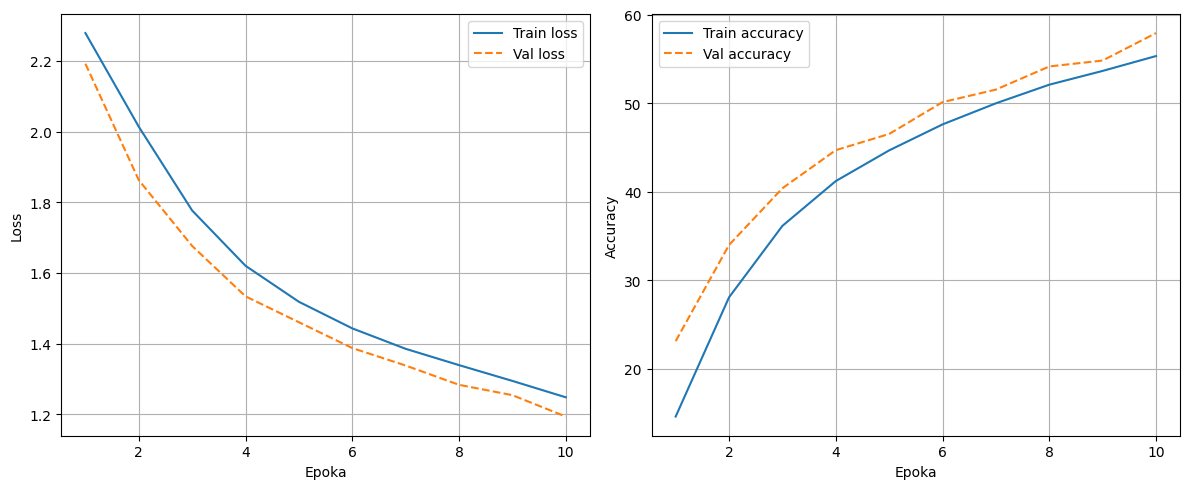

In [36]:
plt.figure(figsize=(12, 5))

plt.subplot(1, 2, 1)
plt.plot(range(1, EPOCHS+1), history['train_loss'], label="Train loss")
plt.plot(range(1, EPOCHS+1), history['val_loss'], label="Val loss", linestyle='--')
plt.xlabel("Epoka")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)


plt.subplot(1, 2, 2)
plt.plot(range(1, EPOCHS+1), history['train_acc'], label="Train accuracy")
plt.plot(range(1, EPOCHS+1), history['val_acc'], label="Val accuracy", linestyle='--')
plt.xlabel("Epoka")
plt.ylabel("Accuracy")
plt.legend()
plt.grid(True)

plt.tight_layout()
plt.show()

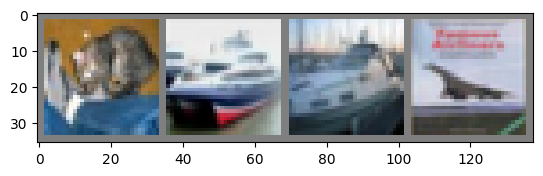

cat  ship ship plane


In [37]:
dataiter = iter(test_loader)
images, labels = next(dataiter)

images = images[:4]
labels = labels[:4]

imshow(torchvision.utils.make_grid(images))
print("".join(f"{classes[labels[j]]:5s}" for j in range(4)))

In [38]:
net.eval()
images = images.to(device)
outputs = net(images)

_, predicted = torch.max(outputs, 1)
print("".join(f"{classes[predicted[j]]:5s}" for j in range(4)))
print("Numer klas przewidzianych przez siec: ", predicted.cpu().numpy())

cat  car  ship ship 
Numer klas przewidzianych przez siec:  [3 1 8 8]


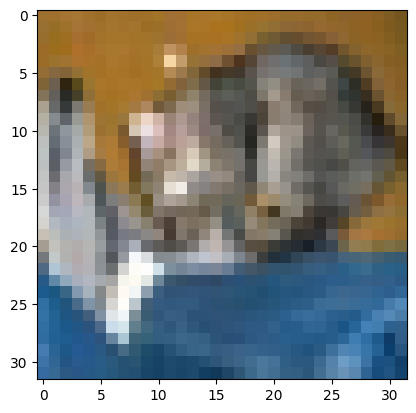

tensor(3)
cat
3
cat
Confidence: 46.71%


In [40]:
import torch.nn.functional as F

dataiter = iter(test_loader)
images, labels = next(dataiter)

img = images[0]
label = labels[0]

imshow(img)
print(label)
print(classes[label])

img_input = img.unsqueeze(0).to(device)
net.eval()
with torch.no_grad():
  output = net(img_input)
  probs = F.softmax(output, dim=1)
  max_prob, predicted_class_index = torch.max(probs, 1)

predicted_index = predicted_class_index.item()
confidence = max_prob.item() * 100
print(predicted_index)
print(classes[predicted_index])
print(f"Confidence: {confidence:.2f}%")

